In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AutoModel
from torchvision import datasets, transforms
from PIL import Image

In [2]:
class MultimodalMNIST(Dataset):
    """Custom dataset that converts MNIST into image-text multimodal format

    Args:
        split (str): Choose either 'train' or 'test' dataset

    Returns:
        dict: {
            'image': torch.Tensor of shape (3, 224, 224),
            'input_ids': torch.Tensor of shape (32,),
            'attention_mask': torch.Tensor of shape (32,),
            'labels': torch.Tensor of shape (10,)
        }

    Example:
        >>> dataset = MultimodalMNIST(split='train')
        >>> sample = dataset[0]
        >>> print(sample['image'].shape)  # torch.Size([3, 224, 224])
        >>> print(sample['input_ids'].shape)  # torch.Size([32])
    """
    def __init__(self, split='train'):
        # Load and preprocess MNIST dataset
        self.mnist = datasets.MNIST(
            './data',
            train=(split == 'train'),
            download=True,
            transform=transforms.Compose([
                transforms.Resize((224, 224)),  # Resize to ViT input size
                transforms.Grayscale(3),        # Convert grayscale to RGB
                transforms.ToTensor(),          # Convert PIL to Tensor
                transforms.Normalize((0.5,), (0.5,))  # Normalize
            ])
        )

        # Text descriptions for each digit
        self.number_descriptions = [
            "A handwritten digit zero",
            "A handwritten digit one",
            "A handwritten digit two",
            "A handwritten digit three",
            "A handwritten digit four",
            "A handwritten digit five",
            "A handwritten digit six",
            "A handwritten digit seven",
            "A handwritten digit eight",
            "A handwritten digit nine"
        ]

        # Initialize BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        """Returns the total number of samples in the dataset"""
        return len(self.mnist)

    def __getitem__(self, idx):
        """Returns a sample for the given index

        Args:
            idx (int): Sample index

        Returns:
            dict: Dictionary containing image, text tokens, and label
        """
        # Get MNIST image and label
        image, label = self.mnist[idx]
        # Get text description for the label
        text = self.number_descriptions[label]

        # Convert text to BERT input format
        encoding = self.tokenizer(
            text,
            padding='max_length',    # Pad to max length
            max_length=32,           # Maximum sequence length
            truncation=True,         # Truncate if exceeds max length
            return_tensors='pt'      # Return PyTorch tensors
        )

        # Create one-hot encoded label
        one_hot_label = torch.zeros(10)
        one_hot_label[label] = 1

        return {
            'image': image,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': one_hot_label
        }


train_dataset = MultimodalMNIST(split='train')
train_loader = DataLoader(
    train_dataset,
    batch_size=32,          # Batch size for training
    shuffle=True,           # Shuffle training data
    num_workers=2           # Number of parallel workers
)

test_dataset = MultimodalMNIST(split='test')
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,          # Don't shuffle test data
    num_workers=2
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


=== Training Dataset Samples ===

Sample 1:
Image shape: torch.Size([3, 224, 224])
Label: 5
Text description: A handwritten digit five

Sample 2:
Image shape: torch.Size([3, 224, 224])
Label: 0
Text description: A handwritten digit zero

Sample 3:
Image shape: torch.Size([3, 224, 224])
Label: 4
Text description: A handwritten digit four

Sample 4:
Image shape: torch.Size([3, 224, 224])
Label: 1
Text description: A handwritten digit one

Sample 5:
Image shape: torch.Size([3, 224, 224])
Label: 9
Text description: A handwritten digit nine


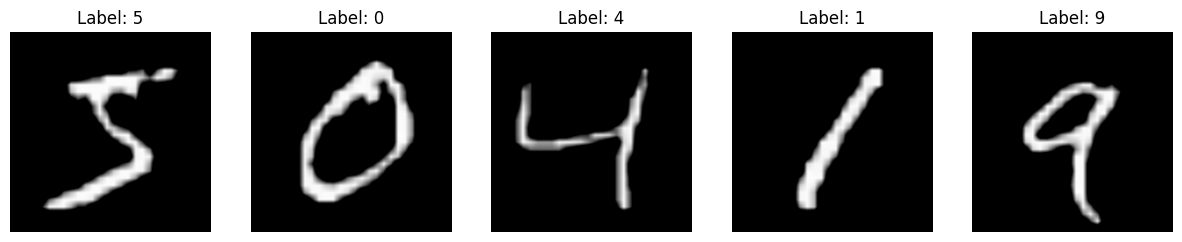

In [3]:
import matplotlib.pyplot as plt

print("=== Training Dataset Samples ===")
for i in range(5):
    sample = train_dataset[i]
    image = sample['image']
    label = sample['labels'].argmax().item()  # one-hot to index
    text = train_dataset.number_descriptions[label]

    print(f"\nSample {i+1}:")
    print(f"Image shape: {image.shape}")
    print(f"Label: {label}")
    print(f"Text description: {text}")

plt.figure(figsize=(15, 3))
for i in range(5):
    sample = train_dataset[i]
    image = sample['image']
    label = sample['labels'].argmax().item()
    text = train_dataset.number_descriptions[label]

    plt.subplot(1, 5, i+1)
    plt.imshow(image.permute(1, 2, 0))  # CHW to HWC
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.show()

In [4]:
class VisualBackbone(nn.Module):
    """Visual backbone network for extracting image features using Swin Transformer V2

    This backbone processes images through Swin Transformer V2 and projects the features
    to a specified hidden dimension. It removes the classification head of Swin and adds
    a projection layer for feature dimension matching.

    Args:
        hidden_size (int): Output feature dimension (default: 768)

    Returns:
        torch.Tensor: Image features of shape (batch_size, hidden_size)

    Example:
        >>> backbone = VisualBackbone(hidden_size=768)
        >>> batch_size = 4
        >>> images = torch.randn(batch_size, 3, 224, 224)  # RGB images
        >>> features = backbone(images)
        >>> print(features.shape)  # torch.Size([4, 768])

    Note:
        Input images should be:
        - Normalized with mean (0.5,) and std (0.5,)
        - Resized to 224x224
        - In RGB format with 3 channels
        - Tensor values in range [-1, 1]

    Architecture:
        1. Swin Transformer V2 (backbone)
           - Input: (batch_size, 3, 224, 224)
           - Output: (batch_size, swin_output_dim)
        2. Projection Layer
           - Linear: swin_output_dim -> hidden_size
           - LayerNorm: hidden_size
    """
    def __init__(self, hidden_size=768):
        super().__init__()
        # Load Swin Transformer V2 model with pretrained weights
        self.swin = models.swin_v2_s(weights=models.Swin_V2_S_Weights.DEFAULT)
        # Get the output dimension of Swin
        swin_output_dim = self.swin.head.in_features  # Usually 768 for Swin-S
        # Remove classification head to get features
        self.swin.head = nn.Identity()

        # Projection layer to match desired hidden size
        self.proj = nn.Sequential(
            nn.Linear(swin_output_dim, hidden_size),
            nn.LayerNorm(hidden_size)
        )

    def forward(self, x):
        """Forward pass through the visual backbone

        Args:
            x (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
                - Channel order: RGB
                - Pixel values: Normalized to [-1, 1]
                - Resolution: 224x224

        Returns:
            torch.Tensor: Image features of shape (batch_size, hidden_size)

        Example:
            >>> backbone = VisualBackbone(hidden_size=768)
            >>> # Create a batch of 4 random images
            >>> images = torch.randn(4, 3, 224, 224)
            >>> # Extract features
            >>> features = backbone(images)
            >>> # Check feature dimensions
            >>> assert features.shape == (4, 768)
        """
        # Pass through Swin Transformer
        x = self.swin(x)  # (batch_size, swin_output_dim)
        # Project to desired hidden size
        x = self.proj(x)  # (batch_size, hidden_size)
        return x

class KnowledgeEncoder(nn.Module):
    """Knowledge encoder for processing text input using BiomedVLP-CXR-BERT

    This encoder processes textual information using a specialized BERT model
    pre-trained on biomedical data.

    Args:
        hidden_size (int): Output feature dimension (default: 768)

    Returns:
        torch.Tensor: Shape (batch_size, sequence_length, hidden_size)

    Example:
        >>> encoder = KnowledgeEncoder(hidden_size=768)
        >>> input_ids = torch.randint(0, 1000, (4, 32))
        >>> attention_mask = torch.ones(4, 32)
        >>> features = encoder(input_ids, attention_mask)
        >>> print(features.shape)  # torch.Size([4, 32, 768])
    """
    def __init__(self, hidden_size=768):
        super().__init__()
        # Load BiomedVLP-CXR-BERT model
        self.bert = AutoModel.from_pretrained('microsoft/BiomedVLP-CXR-BERT-general')

        # Projection layer to match hidden size
        self.proj = nn.Sequential(
            nn.Linear(768, hidden_size),  # BERT's default size is 768
            nn.LayerNorm(hidden_size)
        )

    def forward(self, input_ids, attention_mask):
        """Forward pass

        Args:
            input_ids (torch.Tensor): Token IDs of shape (batch_size, sequence_length)
            attention_mask (torch.Tensor): Attention mask of shape (batch_size, sequence_length)

        Returns:
            torch.Tensor: Encoded features of shape (batch_size, sequence_length, hidden_size)
        """
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.proj(outputs.last_hidden_state)

class DiseaseQueryNetwork(nn.Module):
    """Disease Query Network for feature enhancement using transformer decoder

    This network uses a transformer decoder to enhance visual features
    using knowledge features as context.

    Args:
        hidden_size (int): Feature dimension (default: 768)

    Returns:
        torch.Tensor: Enhanced features of shape (batch_size, hidden_size)

    Example:
        >>> dqn = DiseaseQueryNetwork(hidden_size=768)
        >>> visual_feat = torch.randn(4, 768)
        >>> knowledge_feat = torch.randn(4, 32, 768)
        >>> enhanced = dqn(visual_feat, knowledge_feat)
        >>> print(enhanced.shape)  # torch.Size([4, 768])
    """
    def __init__(self, hidden_size=768):
        super().__init__()
        # Create transformer decoder layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_size,     # Feature dimension
            nhead=8,                 # Number of attention heads
            dim_feedforward=hidden_size*4  # FFN dimension
        )
        # Stack multiple decoder layers
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)

    def forward(self, visual_features, knowledge_features):
        """Forward pass

        Args:
            visual_features (torch.Tensor): Visual features of shape (batch_size, hidden_size)
            knowledge_features (torch.Tensor): Knowledge features of shape (batch_size, seq_len, hidden_size)

        Returns:
            torch.Tensor: Enhanced features of shape (batch_size, hidden_size)
        """
        # Reshape for transformer decoder (seq_len, batch_size, hidden_size)
        knowledge_features = knowledge_features.permute(1, 0, 2)
        # Add sequence dimension to visual features
        visual_features = visual_features.unsqueeze(0)

        # Apply transformer decoder
        return self.decoder(visual_features, knowledge_features)

class KAD(nn.Module):
    """Knowledge-enhanced Auto Diagnosis model

    Main model that combines visual backbone, knowledge encoder, and disease query network
    for multimodal medical image analysis.

    Args:
        num_classes (int): Number of output classes (default: 10)
        hidden_size (int): Hidden dimension size (default: 768)

    Returns:
        dict: {
            'logits': Classification logits of shape (batch_size, num_classes),
            'visual_features': Visual features of shape (batch_size, hidden_size),
            'knowledge_features': Knowledge features of shape (batch_size, seq_len, hidden_size)
        }

    Example:
        >>> model = KAD(num_classes=10, hidden_size=768)
        >>> images = torch.randn(4, 3, 224, 224)
        >>> input_ids = torch.randint(0, 1000, (4, 32))
        >>> attention_mask = torch.ones(4, 32)
        >>> outputs = model(images, input_ids, attention_mask)
        >>> print(outputs['logits'].shape)  # torch.Size([4, 10])
    """
    def __init__(self, num_classes=10, hidden_size=768):
        super().__init__()
        # Initialize component networks
        self.visual_encoder = VisualBackbone(hidden_size)
        self.knowledge_encoder = KnowledgeEncoder(hidden_size)
        self.dqn = DiseaseQueryNetwork(hidden_size)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        """Forward pass

        Args:
            images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
            input_ids (torch.Tensor): Token IDs of shape (batch_size, seq_len)
            attention_mask (torch.Tensor): Attention mask of shape (batch_size, seq_len)

        Returns:
            dict: Dictionary containing logits and features
        """
        # Extract features from each modality
        visual_features = self.visual_encoder(images)
        knowledge_features = self.knowledge_encoder(input_ids, attention_mask)

        # Enhance features using DQN
        enhanced_features = self.dqn(visual_features, knowledge_features)

        # Generate classification logits
        logits = self.classifier(enhanced_features.squeeze(0))

        return {
            'logits': logits,
            'visual_features': visual_features,
            'knowledge_features': knowledge_features
        }

class KADLoss(nn.Module):
    """Loss function for KAD model

    Combines classification loss (BCE) and contrastive loss for multimodal learning.

    Args:
        temperature (float): Temperature parameter for contrastive loss (default: 0.07)

    Example:
        >>> criterion = KADLoss(temperature=0.07)
        >>> outputs = model(images, input_ids, attention_mask)
        >>> loss = criterion(outputs, labels)
    """
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy = nn.CrossEntropyLoss()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, outputs, labels):
        """Calculate total loss

        Args:
            outputs (dict): Model outputs containing 'logits' and features
            labels (torch.Tensor): Ground truth labels

        Returns:
            torch.Tensor: Combined loss value
        """
        # Classification loss using BCE
        cls_loss = self.bce(outputs['logits'], labels)

        # Contrastive loss between visual and knowledge features
        visual_features = F.normalize(outputs['visual_features'], dim=-1)
        knowledge_features = F.normalize(outputs['knowledge_features'], dim=-1)

        # Calculate similarity matrix
        sim_matrix = torch.matmul(visual_features, knowledge_features.transpose(-2, -1))
        sim_matrix /= self.temperature

        # Create target matrix for contrastive learning
        batch_size = len(visual_features)
        target = torch.zeros_like(sim_matrix)
        target[torch.arange(batch_size), torch.arange(batch_size)] = 1

        # Calculate contrastive loss using BCE
        cont_loss = self.bce(sim_matrix, target)

        # Return combined loss
        return cls_loss + cont_loss

In [5]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=5):
    """Train the KAD model

    Args:
        model (nn.Module): KAD model instance
        train_loader (DataLoader): Training data loader
        criterion (nn.Module): Loss function (KADLoss)
        optimizer (torch.optim): Optimizer instance
        device (torch.device): Device to run training on
        num_epochs (int): Number of training epochs (default: 5)

    Example:
        >>> model = KAD(num_classes=10)
        >>> criterion = KADLoss()
        >>> optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
        >>> train(model, train_loader, criterion, optimizer, device, num_epochs=5)
    """
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, batch in enumerate(train_loader):
            # Move batch data to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            optimizer.zero_grad()  # Clear gradients
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            total_loss += loss.item()
            pred = outputs['logits'].argmax(dim=1)
            true = labels.argmax(dim=1)
            correct += pred.eq(true).sum().item()
            total += labels.size(0)

            # Print progress
            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}], Batch [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KAD(num_classes=10, hidden_size=768).to(device)
criterion = KADLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

num_epochs = 1
train(model, train_loader, criterion, optimizer, device, num_epochs)

torch.save(model.state_dict(), 'kad_mnist.pth')

Epoch [1], Batch [50/1875], Loss: 0.4025, Acc: 18.56%
Epoch [1], Batch [100/1875], Loss: 0.1673, Acc: 51.28%
Epoch [1], Batch [150/1875], Loss: 0.1108, Acc: 67.21%
Epoch [1], Batch [200/1875], Loss: 0.1119, Acc: 75.31%
Epoch [1], Batch [250/1875], Loss: 0.0908, Acc: 80.19%
Epoch [1], Batch [300/1875], Loss: 0.0969, Acc: 83.48%
Epoch [1], Batch [350/1875], Loss: 0.0867, Acc: 85.83%
Epoch [1], Batch [400/1875], Loss: 0.0886, Acc: 87.60%
Epoch [1], Batch [450/1875], Loss: 0.0914, Acc: 88.97%
Epoch [1], Batch [500/1875], Loss: 0.0820, Acc: 90.08%
Epoch [1], Batch [550/1875], Loss: 0.0787, Acc: 90.98%
Epoch [1], Batch [600/1875], Loss: 0.0724, Acc: 91.73%
Epoch [1], Batch [650/1875], Loss: 0.0818, Acc: 92.37%
Epoch [1], Batch [700/1875], Loss: 0.0890, Acc: 92.91%
Epoch [1], Batch [750/1875], Loss: 0.0794, Acc: 93.38%
Epoch [1], Batch [800/1875], Loss: 0.0911, Acc: 93.80%
Epoch [1], Batch [850/1875], Loss: 0.0765, Acc: 94.16%
Epoch [1], Batch [900/1875], Loss: 0.0824, Acc: 94.49%
Epoch [1], 

In [9]:
def evaluate(model, test_loader, device):
    """Evaluate the KAD model

    Args:
        model (nn.Module): KAD model instance
        test_loader (DataLoader): Test data loader
        device (torch.device): Device to run evaluation on

    Returns:
        float: Test accuracy percentage

    Example:
        >>> model = KAD(num_classes=10)
        >>> model.load_state_dict(torch.load('kad_mnist.pth'))
        >>> accuracy = evaluate(model, test_loader, device)
        >>> print(f'Test Accuracy: {accuracy:.2f}%')
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(images, input_ids, attention_mask)
            pred = outputs['logits'].argmax(dim=1)
            true = labels.argmax(dim=1)

            correct += pred.eq(true).sum().item()
            total += labels.size(0)

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

In [10]:
model = KAD(num_classes=10, hidden_size=768).to(device)
model.load_state_dict(torch.load('kad_mnist.pth'))

evaluate(model, test_loader, device)

<ipython-input-10-34fc71f2ee2f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('kad_mnist.pth'))


Test Accuracy: 100.00%


100.0

In [19]:
class KADInference(nn.Module):
    """Inference class for KAD model with zero-shot capabilities

    Args:
        model_path (str, optional): Path to pretrained model weights

    Example:
        >>> inference_model = KADInference('kad_mnist.pth')
        >>> image = Image.open('test_digit.png')
        >>> text_prompt = "This is a handwritten zero"
        >>> similarity = inference_model.zero_shot_inference(image, text_prompt, device)
        >>> print(f"Similarity score: {similarity:.4f}")
    """
    def __init__(self, model_path=None):
        super().__init__()
        # Initialize KAD model
        self.model = KAD(num_classes=10, hidden_size=768)
        if model_path:
            self.model.load_state_dict(torch.load(model_path))
        # Initialize tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def zero_shot_inference(self, image, text_prompt, device):
        """Perform zero-shot inference using image and text prompt

        Args:
            image (PIL.Image): Input image
            text_prompt (str): Text description for comparison
            device (torch.device): Device to run inference on

        Returns:
            float: Similarity score between image and text prompt
        """
        self.model.eval()
        with torch.no_grad():
            # Preprocess image
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.Grayscale(3),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            image = transform(image).unsqueeze(0).to(device)

            # Preprocess text prompt
            encoding = self.tokenizer(
                text_prompt,
                padding='max_length',
                max_length=32,
                truncation=True,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # Model inference
            outputs = self.model(image, input_ids, attention_mask)

            # Calculate similarity between visual and text features
            # Take mean of knowledge features across sequence length
            knowledge_features_mean = outputs['knowledge_features'].mean(dim=1)  # Average across sequence length
            similarity = F.cosine_similarity(
                outputs['visual_features'],
                knowledge_features_mean,
                dim=-1
            )
            return similarity.item()

In [20]:
# Example usage
def infer():
    """Demonstrate zero-shot inference with KAD model

    Example:
        >>> infer()
        Predicted digit: 7
        Similarities: {0: '0.1234', 1: '0.2345', ...}
    """
    # Setup device and model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inference_model = KADInference('kad_mnist.pth').to(device)

    # Load test image
    test_image = Image.open('3.png').convert('RGB')

    # Define zero-shot prompts
    prompts = [
        "This is a handwritten zero",
        "This is a handwritten one",
        "This is a handwritten two",
        "This is a handwritten three",
        "This is a handwritten four",
        "This is a handwritten five",
        "This is a handwritten six",
        "This is a handwritten seven",
        "This is a handwritten eight",
        "This is a handwritten nine"
    ]

    # Calculate similarity for each prompt
    similarities = []
    for prompt in prompts:
        similarity = inference_model.zero_shot_inference(test_image, prompt, device)
        similarities.append(similarity)

    # Get prediction
    predicted_class = similarities.index(max(similarities))
    print(f"Predicted digit: {predicted_class}")
    print("Similarities:", {i: f"{sim:.4f}" for i, sim in enumerate(similarities)})

infer()

<ipython-input-19-0ba4a2fefc3e>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


Predicted digit: 3
Similarities: {0: '-0.4324', 1: '-0.4937', 2: '-0.4404', 3: '-0.0262', 4: '-0.4884', 5: '-0.4533', 6: '-0.4940', 7: '-0.4046', 8: '-0.4635', 9: '-0.4054'}


# Troubleshooting and Error Summary

## Initial Error:
### - Error Type: AssertionError
### - Cause: In the DiseaseQueryNetwork's forward pass, the nn.TransformerDecoder expected an incorrect shape for the memory input (knowledge_features). The decoder expected the shape (sequence length, batch size, embedding dimension), but knowledge_features had the shape (batch size, sequence length, embedding dimension) due to the output of the BERT model.
### - Solution: Reordered the dimensions of knowledge_features using permute(1, 0, 2) and added a sequence length dimension to visual_features.

## Second Error:
### - Error Type: RuntimeError
### - Cause: In the KADLoss class, when calculating the contrastive loss, there was a mismatch between the shape of the target tensor expected by the cross_entropy function and the shape of the provided target tensor. cross_entropy expected the shape (batch size, num_classes), but the target tensor created using torch.arange(len(visual_features)) had the shape (batch_size).
### - Solution: Created a target tensor with the same shape as sim_matrix and set the diagonal elements to 1, indicating that a visual feature should be most similar to its corresponding knowledge feature. Also changed to use BCEWithLogitsLoss for the contrastive loss to perform binary classification.